<a href="https://colab.research.google.com/github/matthew9671/MattLab/blob/main/Kalman_Filtering_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To test the correctness and stability of various different methods for Kalman Filtering and smoothing, we put multiple different implementation under the same standard framework and test them.

1. Info-form block tri-diagonal matrix inversion

    Alternative implementation of the scan step?

    Manual symmetrization of the filtered/smoothed statistics?

2. Associative parallel scan

    Alternative method of computing log normalizer?

    Information form associative operator?

TODOs:

- [x] Initialize the starting elements with recognition potentials instead of emission matrices and biases
- [x] Test its correctness by comparing with the emission and bias version
- [x] Implement the same thing but for smoothing (hey, turns out it doesn't change!)
- [ ] Make a distribution object for sampling and evaluating likelihoods
- [x] Test its correctness by comparing with the block tridiag version
- [ ] Also test these against the sequential version in Dynamax
- [ ] Add in the dynamic bias b

In [1]:
# This reloads files not modules
%load_ext autoreload
%autoreload 2

In [2]:
# @title Download stuff 
import os
# Download and install the relevant libraries
!pip install -q ml-collections git+https://github.com/google/flax
# !pip install -q wandb
!pip install dynamax

     |████████████████████████████████| 77 kB 2.1 MB/s 
     |████████████████████████████████| 154 kB 20.9 MB/s 
     |████████████████████████████████| 65 kB 2.2 MB/s 
     |████████████████████████████████| 8.3 MB 9.6 MB/s 
     |████████████████████████████████| 237 kB 18.3 MB/s 
     |████████████████████████████████| 51 kB 3.3 MB/s 
     |████████████████████████████████| 85 kB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 121 kB 6.2 MB/s 
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1


In [3]:
# @title Imports
# Misc
import os
from importlib import reload
import numpy as onp
import matplotlib.pyplot as plt
from functools import partial
from tqdm import trange
import copy, traceback
from pprint import pprint
from copy import deepcopy
import pickle as pkl

# Debug
import pdb
# Jax
import jax
from jax import vmap, lax, jit, value_and_grad
import jax.numpy as np
import jax.scipy as jsc
import jax.random as jr
key_0 = jr.PRNGKey(0) # Convenience
from jax.lax import scan
from jax.tree_util import tree_map

# Tensorflow probability
import tensorflow_probability.substrates.jax as tfp
import tensorflow_probability.substrates.jax.distributions as tfd
from tensorflow_probability.substrates.jax.distributions \
    import MultivariateNormalFullCovariance as MVN

# Common math functions
from flax.linen import softplus, sigmoid
from jax.scipy.special import logsumexp
from jax.scipy.linalg import solve_triangular, solve
from jax.numpy.linalg import eigh, cholesky, svd, inv, solve

# Dynamax stuff
from dynamax.linear_gaussian_ssm import LinearGaussianSSM

# For making nice visualizations
from sklearn.decomposition import PCA
from IPython.display import clear_output, HTML
from matplotlib import animation, rc
import seaborn as sns
color_names = ["windows blue",
                "red",
                "amber",
                "faded green",
                "dusty purple",
                "orange",
                "clay",
                "pink",
                "greyish",
                "mint",
                "light cyan",
                "steel blue",
                "forest green",
                "pastel purple",
                "salmon",
                "dark brown",
               "violet",
               "mauve",
               "ocean",
               "ugly yellow"]
colors = sns.xkcd_palette(color_names)

# Get rid of the check types warning
import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [4]:
# @title MVN tridiag object (taken from ssm)
from tensorflow_probability.python.internal import reparameterization

def block_tridiag_mvn_log_normalizer(J_diag, J_lower_diag, h):
    """ TODO
    """
    # extract dimensions
    num_timesteps, dim = J_diag.shape[:2]

    # Pad the L's with one extra set of zeros for the last predict step
    J_lower_diag_pad = np.concatenate((J_lower_diag, np.zeros((1, dim, dim))), axis=0)

    def marginalize(carry, t):
        Jp, hp, lp = carry

        # Condition
        Jc = J_diag[t] + Jp
        hc = h[t] + hp

        # Predict -- Cholesky approach seems unstable!
        sqrt_Jc = np.linalg.cholesky(Jc)
        trm1 = solve_triangular(sqrt_Jc, hc, lower=True)
        trm2 = solve_triangular(sqrt_Jc, J_lower_diag_pad[t].T, lower=True)
        log_Z = 0.5 * dim * np.log(2 * np.pi)
        log_Z += -np.sum(np.log(np.diag(sqrt_Jc)))  # sum these terms only to get approx log|J|
        log_Z += 0.5 * np.dot(trm1.T, trm1)
        Jp = -np.dot(trm2.T, trm2)
        hp = -np.dot(trm2.T, trm1)

        # Alternative predict step:
        # log_Z = 0.5 * dim * np.log(2 * np.pi)
        # log_Z += -0.5 * np.linalg.slogdet(Jc)[1]
        # log_Z += 0.5 * np.dot(hc, np.linalg.solve(Jc, hc))
        # Jp = -np.dot(J_lower_diag_pad[t], np.linalg.solve(Jc, J_lower_diag_pad[t].T))
        # # Jp = (Jp + Jp.T) * .5   # Manual symmetrization
        # hp = -np.dot(J_lower_diag_pad[t], np.linalg.solve(Jc, hc))

        new_carry = Jp, hp, lp + log_Z
        return new_carry, (Jc, hc)

    # Initialize
    Jp0 = np.zeros((dim, dim))
    hp0 = np.zeros((dim,))
    (_, _, log_Z), (filtered_Js, filtered_hs) = lax.scan(marginalize, (Jp0, hp0, 0), np.arange(num_timesteps))
    return log_Z, (filtered_Js, filtered_hs)

class MultivariateNormalBlockTridiag(tfd.Distribution):
    """
    The Gaussian linear dynamical system's posterior distribution over latent states
    is a multivariate normal distribution whose _precision_ matrix is
    block tridiagonal.

        x | y ~ N(\mu, \Sigma)

    where

        \Sigma^{-1} = J = [[J_{0,0},   J_{0,1},   0,       0,      0],
                           [J_{1,0},   J_{1,1},   J_{1,2}, 0,      0],
                           [0,         J_{2,1},   J_{2,2}, \ddots, 0],
                           [0,         0,         \ddots,  \ddots,  ],

    is block tridiagonal, and J_{t, t+1} = J_{t+1, t}^T.

    The pdf is

        p(x) = exp \{-1/2 x^T J x + x^T h - \log Z(J, h) \}
             = exp \{- 1/2 \sum_{t=1}^T x_t^T J_{t,t} x_t
                     - \sum_{t=1}^{T-1} x_{t+1}^T J_{t+1,t} x_t
                     + \sum_{t=1}^T x_t^T h_t
                     -\log Z(J, h)\}

    where J = \Sigma^{-1} and h = \Sigma^{-1} \mu = J \mu.

    Using exponential family tricks we know that

        E[x_t] = \grad_{h_t} \log Z(J, h)
        E[x_t x_t^T] = -2 \grad_{J_{t,t}} \log Z(J, h)
        E[x_{t+1} x_t^T] = -\grad_{J_{t+1,t}} \log Z(J, h)

    These are the expectations we need for EM.
    """
    def __init__(self,
                 precision_diag_blocks,
                 precision_lower_diag_blocks,
                 linear_potential,
                 log_normalizer,
                 filtered_precisions,
                 filtered_linear_potentials,
                 expected_states,
                 expected_states_squared,
                 expected_states_next_states,
                 validate_args=False,
                 allow_nan_stats=True,
                 name="MultivariateNormalBlockTridiag",
             ) -> None:

        self._precision_diag_blocks = precision_diag_blocks
        self._precision_lower_diag_blocks = precision_lower_diag_blocks
        self._linear_potential = linear_potential
        self._log_normalizer = log_normalizer
        self._filtered_precisions = filtered_precisions
        self._filtered_linear_potentials = filtered_linear_potentials
        self._expected_states = expected_states
        self._expected_states_squared = expected_states_squared
        self._expected_states_next_states = expected_states_next_states

        # We would detect the dtype dynamically but that would break vmap
        # see https://github.com/tensorflow/probability/issues/1271
        dtype = np.float32
        super(MultivariateNormalBlockTridiag, self).__init__(
            dtype=dtype,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            reparameterization_type=reparameterization.NOT_REPARAMETERIZED,
            parameters=dict(precision_diag_blocks=self._precision_diag_blocks,
                            precision_lower_diag_blocks=self._precision_lower_diag_blocks,
                            linear_potential=self._linear_potential,
                            log_normalizer=self._log_normalizer,
                            filtered_precisions=self._filtered_precisions,
                            filtered_linear_potentials=self._filtered_linear_potentials,
                            expected_states=self._expected_states,
                            expected_states_squared=self._expected_states_squared,
                            expected_states_next_states=self._expected_states_next_states),
            name=name,
        )

    @classmethod
    def _parameter_properties(cls, dtype, num_classes=None):
        # pylint: disable=g-long-lambda
        return dict(
            precision_diag_blocks=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
            precision_lower_diag_blocks=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
            linear_potential=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
            log_normalizer=tfp.internal.parameter_properties.ParameterProperties(event_ndims=0),
            filtered_precisions=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
            filtered_linear_potentials=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
            expected_states=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
            expected_states_squared=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
            expected_states_next_states=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
        )

    @classmethod
    def infer(cls,
              precision_diag_blocks,
              precision_lower_diag_blocks,
              linear_potential):
        assert precision_diag_blocks.ndim == 3
        num_timesteps, dim = precision_diag_blocks.shape[:2]
        assert precision_diag_blocks.shape[2] == dim
        assert precision_lower_diag_blocks.shape == (num_timesteps - 1, dim, dim)
        assert linear_potential.shape == (num_timesteps, dim)

        # Run message passing code to get the log normalizer, the filtering potentials,
        # and the expected values of x. Technically, the natural parameters are -1/2 J
        # so we need to do a little correction of the gradients to get the expectations.
        f = value_and_grad(block_tridiag_mvn_log_normalizer, argnums=(0, 1, 2), has_aux=True)
        (log_normalizer, (filtered_precisions, filtered_linear_potentials)), grads = \
            f(precision_diag_blocks, precision_lower_diag_blocks, linear_potential)

        # Manually symmetrize ExxT due to numerical issues...!!!
        # Correct for the -1/2 J -> J implementation
        expected_states_squared = - grads[0] - np.swapaxes(grads[0], -2, -1)
        expected_states_next_states = -grads[1]
        expected_states = grads[2]

        return cls(precision_diag_blocks,
                   precision_lower_diag_blocks,
                   linear_potential,
                   log_normalizer,
                   filtered_precisions,
                   filtered_linear_potentials,
                   expected_states,
                   expected_states_squared,
                   expected_states_next_states)

    @classmethod
    def infer_from_precision_and_mean(cls,
                                      precision_diag_blocks,
                                      precision_lower_diag_blocks,
                                      mean):
        assert precision_diag_blocks.ndim == 3
        num_timesteps, dim = precision_diag_blocks.shape[:2]
        assert precision_diag_blocks.shape[2] == dim
        assert precision_lower_diag_blocks.shape == (num_timesteps - 1, dim, dim)
        assert mean.shape == (num_timesteps, dim)

        # Convert the mean to the linear potential
        linear_potential = np.einsum('tij,tj->ti', precision_diag_blocks, mean)
        linear_potential = linear_potential.at[:-1].add(
            np.einsum('tji,tj->ti', precision_lower_diag_blocks, mean[1:]))
        linear_potential = linear_potential.at[1:].add(
            np.einsum('tij,tj->ti', precision_lower_diag_blocks, mean[:-1]))

        # Call the constructor above
        return cls.infer(precision_diag_blocks,
                         precision_lower_diag_blocks,
                         linear_potential)

    # Properties to get private class variables
    @property
    def precision_diag_blocks(self):
        return self._precision_diag_blocks

    @property
    def precision_lower_diag_blocks(self):
        return self._precision_lower_diag_blocks

    @property
    def linear_potential(self):
        return self._linear_potential

    @property
    def log_normalizer(self):
        return self._log_normalizer

    @property
    def filtered_precisions(self):
        return self._filtered_precisions

    @property
    def filtered_linear_potentials(self):
        return self._filtered_linear_potentials

    @property
    def expected_states(self):
        return self._expected_states

    @property
    def expected_states_squared(self):
        return self._expected_states_squared

    @property
    def expected_states_next_states(self):
        return self._expected_states_next_states

    def _log_prob(self, data, **kwargs):
        lp = -0.5 * np.einsum('...ti,...tij,...tj->...', data, self._precision_diag_blocks, data)
        lp += -np.einsum('...ti,...tij,...tj->...', data[...,1:,:], self._precision_lower_diag_blocks, data[...,:-1,:])
        lp += np.einsum('...ti,...ti->...', data, self._linear_potential)
        lp -= self.log_normalizer
        return lp

    def _mean(self):
        return self.expected_states

    def _covariance(self):
        """
        NOTE: This computes the _marginal_ covariance Cov[x_t] for each t
        """
        Ex = self._expected_states
        ExxT = self._expected_states_squared
        return ExxT - np.einsum("...i,...j->...ij", Ex, Ex)

    def _sample_n(self, n, seed=None):
        filtered_Js = self._filtered_precisions
        filtered_hs = self._filtered_linear_potentials
        J_lower_diag = self._precision_lower_diag_blocks

        def sample_single(seed, filtered_Js, filtered_hs, J_lower_diag):

            def _sample_info_gaussian(seed, J, h, sample_shape=()):
                # TODO: avoid inversion.
                # see https://github.com/mattjj/pybasicbayes/blob/master/pybasicbayes/util/stats.py#L117-L122
                # L = np.linalg.cholesky(J)
                # x = np.random.randn(h.shape[0])
                # return scipy.linalg.solve_triangular(L,x,lower=True,trans='T') \
                #     + dpotrs(L,h,lower=True)[0]
                cov = np.linalg.inv(J)
                loc = np.einsum("...ij,...j->...i", cov, h)
                return tfp.distributions.MultivariateNormalFullCovariance(
                    loc=loc, covariance_matrix=cov).sample(sample_shape=sample_shape, seed=seed)

            def _step(carry, inpt):
                x_next, seed = carry
                Jf, hf, L = inpt

                # Condition on the next observation
                Jc = Jf
                hc = hf - np.einsum('ni,ij->nj', x_next, L)

                # Split the seed
                seed, this_seed = jr.split(seed)
                x = _sample_info_gaussian(this_seed, Jc, hc)
                return (x, seed), x

            # Initialize with sample of last timestep and sample in reverse
            seed_T, seed = jr.split(seed)
            x_T = _sample_info_gaussian(seed_T, filtered_Js[-1], filtered_hs[-1], sample_shape=(n,))
            inputs = (filtered_Js[:-1][::-1], filtered_hs[:-1][::-1], J_lower_diag[::-1])
            _, x_rev = lax.scan(_step, (x_T, seed), inputs)

            # Reverse and concatenate the last time-step's sample
            x = np.concatenate((x_rev[::-1], x_T[None, ...]), axis=0)

            # Transpose to be (num_samples, num_timesteps, dim)
            return np.transpose(x, (1, 0, 2))

        # TODO: Handle arbitrary batch shapes
        if filtered_Js.ndim == 4:
            # batch mode
            samples = vmap(sample_single)(seed, filtered_Js, filtered_hs, J_lower_diag)
            # Transpose to be (num_samples, num_batches, num_timesteps, dim)
            samples = np.transpose(samples, (1, 0, 2, 3))
        else:
            # non-batch mode
            samples = sample_single(seed, filtered_Js, filtered_hs, J_lower_diag)
        return samples

    def _entropy(self):
        """
        Compute the entropy

            H[X] = -E[\log p(x)]
                 = -E[-1/2 x^T J x + x^T h - log Z(J, h)]
                 = 1/2 <J, E[x x^T] - <h, E[x]> + log Z(J, h)
        """
        Ex = self._expected_states
        ExxT = self._expected_states_squared
        ExnxT = self._expected_states_next_states
        J_diag = self._precision_diag_blocks
        J_lower_diag = self._precision_lower_diag_blocks
        h = self._linear_potential

        entropy = 0.5 * np.sum(J_diag * ExxT)
        entropy += np.sum(J_lower_diag * ExnxT)
        entropy -= np.sum(h * Ex)
        entropy += self.log_normalizer
        return entropy

    def tree_flatten(self):
        children = (self._precision_diag_blocks,
                    self._precision_lower_diag_blocks,
                    self._linear_potential,
                    self._log_normalizer,
                    self._filtered_precisions,
                    self._filtered_linear_potentials,
                    self._expected_states,
                    self._expected_states_squared,
                    self._expected_states_next_states)
        aux_data = None
        return children, aux_data

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

In [5]:
# @title Math helpers for the MVN tridiag object

# Computes ATQ-1A in a way that's guaranteed to be symmetric
def inv_quad_form(Q, A):
    sqrt_Q = np.linalg.cholesky(Q)
    trm = solve_triangular(sqrt_Q, A, lower=True, check_finite=False)
    return trm.T @ trm

def inv_symmetric(Q):
    sqrt_Q = np.linalg.cholesky(Q)
    sqrt_Q_inv = np.linalg.inv(sqrt_Q)
    return sqrt_Q_inv.T @ sqrt_Q_inv

# Converts from (A, b, Q) to (J, L, h)
def dynamics_to_tridiag(dynamics_params, T, D):
    Q1, m1, A, Q, b = dynamics_params["Q1"], \
        dynamics_params["m1"], dynamics_params["A"], \
        dynamics_params["Q"], dynamics_params["b"]
    # diagonal blocks of precision matrix
    J = np.zeros((T, D, D))
    J = J.at[0].add(inv_symmetric(Q1))

    J = J.at[:-1].add(inv_quad_form(Q, A))
    J = J.at[1:].add(inv_symmetric(Q))
    # lower diagonal blocks of precision matrix
    L = -np.linalg.solve(Q, A)
    L = np.tile(L[None, :, :], (T - 1, 1, 1))
    # linear potential
    h = np.zeros((T, D)) 
    h = h.at[0].add(np.linalg.solve(Q1, m1))
    h = h.at[:-1].add(-np.dot(A.T, np.linalg.solve(Q, b)))
    h = h.at[1:].add(np.linalg.solve(Q, b))
    return { "J": J, "L": L, "h": h }

In [6]:
# @title Parallel Kalman filtering from Dynamax

def psd_solve(A,b):
    """A wrapper for coordinating the linalg solvers used in the library for psd matrices."""
    A = A + 1e-6
    return np.linalg.solve(A,b)

def _make_associative_filtering_elements(params, emissions):
    """Preprocess observations to construct input for filtering assocative scan."""

    def _first_filtering_element(params, y):
        F = params.dynamics.weights
        H = params.emissions.weights
        Q = params.dynamics.cov
        R = params.emissions.cov
        P0 = params.initial.cov

        S = H @ Q @ H.T + R
        CF, low = jsc.linalg.cho_factor(S)

        m1 = params.initial.mean
        P1 = params.initial.cov
        S1 = H @ P1 @ H.T + R
        K1 = psd_solve(S1, H @ P1).T

        A = np.zeros_like(F)
        b = m1 + K1 @ (y - H @ m1)
        C = P1 - K1 @ S1 @ K1.T
        # TODO: why do these values make sense for the first element??
        eta = F.T @ H.T @ jsc.linalg.cho_solve((CF, low), y)
        J = F.T @ H.T @ jsc.linalg.cho_solve((CF, low), H @ F)

        logZ = -MVN(loc=np.zeros_like(y), covariance_matrix=H @ P0 @ H.T + R).log_prob(y)

        return A, b, C, J, eta, logZ


    def _generic_filtering_element(params, y):
        F = params.dynamics.weights
        H = params.emissions.weights
        Q = params.dynamics.cov
        R = params.emissions.cov

        S = H @ Q @ H.T + R
        CF, low = jsc.linalg.cho_factor(S)
        K = jsc.linalg.cho_solve((CF, low), H @ Q).T
        A = F - K @ H @ F
        b = K @ y
        C = Q - K @ H @ Q

        eta = F.T @ H.T @ jsc.linalg.cho_solve((CF, low), y)
        J = F.T @ H.T @ jsc.linalg.cho_solve((CF, low), H @ F)

        logZ = -MVN(loc=np.zeros_like(y), covariance_matrix=S).log_prob(y)

        return A, b, C, J, eta, logZ

    first_elems = _first_filtering_element(params, emissions[0])
    generic_elems = vmap(_generic_filtering_element, (None, 0))(params, emissions[1:])
    combined_elems = tuple(np.concatenate((first_elm[None,...], gen_elm))
                           for first_elm, gen_elm in zip(first_elems, generic_elems))
    return combined_elems

def lgssm_filter(params, emissions):
    """A parallel version of the lgssm filtering algorithm.
    See S. Särkkä and Á. F. García-Fernández (2021) - https://arxiv.org/abs/1905.13002.
    Note: This function does not yet handle `inputs` to the system.
    """

    initial_elements = _make_associative_filtering_elements(params, emissions)

    @vmap
    def filtering_operator(elem1, elem2):
        A1, b1, C1, J1, eta1, logZ1 = elem1
        A2, b2, C2, J2, eta2, logZ2 = elem2
        dim = A1.shape[0]
        I = np.eye(dim)

        I_C1J2 = I + C1 @ J2
        temp = jsc.linalg.solve(I_C1J2.T, A2.T).T
        A = temp @ A1
        b = temp @ (b1 + C1 @ eta2) + b2
        C = temp @ C1 @ A2.T + C2

        I_J2C1 = I + J2 @ C1
        temp = jsc.linalg.solve(I_J2C1.T, A1).T

        eta = temp @ (eta2 - J2 @ b1) + eta1
        J = temp @ J2 @ A1 + J1

        # mu = jsc.linalg.solve(J2, eta2)
        # t2 = - eta2 @ mu + (b1 - mu) @ jsc.linalg.solve(I_J2C1, (J2 @ b1 - eta2))

        mu = np.linalg.solve(C1, b1)
        t1 = (b1 @ mu - (eta2 + mu) @ np.linalg.solve(I_C1J2, C1 @ eta2 + b1))

        logZ = (logZ1 + logZ2 + 0.5 * np.linalg.slogdet(I_C1J2)[1] + 0.5 * t1)

        return A, b, C, J, eta, logZ

    _, filtered_means, filtered_covs, _, _, logZ = lax.associative_scan(
                                                filtering_operator, initial_elements
                                                )

    return {
        "marginal_logliks": - logZ,
        "marginal_loglik": - logZ[-1],
        "filtered_means": filtered_means, 
        "filtered_covariances": filtered_covs
    }

def _make_associative_smoothing_elements(params, filtered_means, filtered_covariances):
    """Preprocess filtering output to construct input for smoothing assocative scan."""

    def _last_smoothing_element(m, P):
        return np.zeros_like(P), m, P

    def _generic_smoothing_element(params, m, P):
        F = params.dynamics.weights
        # H = params.emissions.weights
        Q = params.dynamics.cov
        # R = params.emissions.cov

        Pp = F @ P @ F.T + Q

        E  = psd_solve(Pp, F @ P).T
        g  = m - E @ F @ m
        L  = P - E @ Pp @ E.T
        return E, g, L

    last_elems = _last_smoothing_element(filtered_means[-1], filtered_covariances[-1])
    generic_elems = vmap(_generic_smoothing_element, (None, 0, 0))(
        params, filtered_means[:-1], filtered_covariances[:-1]
        )
    combined_elems = tuple(np.append(gen_elm, last_elm[None,:], axis=0)
                           for gen_elm, last_elm in zip(generic_elems, last_elems))
    return combined_elems


def parallel_lgssm_smoother(params, emissions):
    """A parallel version of the lgssm smoothing algorithm.
    See S. Särkkä and Á. F. García-Fernández (2021) - https://arxiv.org/abs/1905.13002.
    Note: This function does not yet handle `inputs` to the system.
    """
    filtered_posterior = lgssm_filter(params, emissions)
    filtered_means = filtered_posterior["filtered_means"]
    filtered_covs = filtered_posterior["filtered_covariances"]
    initial_elements = _make_associative_smoothing_elements(params, filtered_means, filtered_covs)

    @vmap
    def smoothing_operator(elem1, elem2):
        E1, g1, L1 = elem1
        E2, g2, L2 = elem2

        E = E2 @ E1
        g = E2 @ g1 + g2
        L = E2 @ L1 @ E2.T + L2

        return E, g, L

    _, smoothed_means, smoothed_covs, *_ = lax.associative_scan(
                                                smoothing_operator, initial_elements, reverse=True
                                                )
    return {
        "marginal_loglik": filtered_posterior["marginal_loglik"],
        "filtered_means": filtered_means,
        "filtered_covariances": filtered_covs,
        "smoothed_means": smoothed_means,
        "smoothed_covariances": smoothed_covs
    }

In [7]:
# @title Augment the original function for it to work with recognition potentials
def _make_filtering_elements_with_rec_potentials(params, potentials):

    F = params["A"]
    Q = params["Q"]
    Q1 = params["Q1"]
    m1 = params["m1"]
    dim = Q.shape[0]

    def _first_filtering_element(J_obs, h_obs):
        IpQ1J = np.eye(dim) + Q1 @ J_obs
        C = solve(IpQ1J, Q1)
        b = C @ (h_obs + solve(Q1, m1))
        A = np.zeros_like(F)

        IpQJ = np.eye(dim) + Q @ J_obs
        IpJQ = np.eye(dim) + J_obs @ Q

        eta = F.T @ solve(IpJQ, h_obs)
        J = F.T @ J_obs @ solve(IpQJ, F)

        # We need to take into account the fact that J might be non-invertible
        logZ_tilde = 0.5 * np.linalg.slogdet(IpQ1J)[1] - 0.5 * h_obs.T @ Q1 @ solve(IpQ1J, h_obs)
        
        # mu_obs = solve(J_obs, h_obs)
        # Sigma_obs = inv(J_obs)
        # logZ_tilde = -MVN(loc=np.zeros(dim), covariance_matrix=Q+Sigma_obs).log_prob(mu_obs)
        
        # Note: logZ = logZ_tilde - log(n_t) where n_t is an unknown constant 
        # that is cancelled when we compute the posterior log likelihood

        return A, b, C, J, eta, logZ_tilde

    def _generic_filtering_element(J_obs, h_obs):
        # C = (Q^{-1} + J_{obs})^{-1} = (I + QJ_{obs})^{-1}Q
        IpQJ = np.eye(dim) + Q @ J_obs
        IpJQ = np.eye(dim) + J_obs @ Q
        C = solve(IpQJ, Q)
        b = C @ h_obs
        A = solve(IpQJ, F)

        # eta = F^T(I+J_{obs}Q)^{-1}h_{obs}
        # J = F^T(Q+J_{obs}^{-1})^{-1}F = F^TJ_{obs}(I +QJ_{obs})^{-1}F
        # This is the same update as in the associative operator...!
        eta = F.T @ solve(IpJQ, h_obs)
        J = F.T @ J_obs @ solve(IpQJ, F) # This can be replaced with A

        # We need to take into account the fact that J might be non-invertible
        logZ_tilde = 0.5 * np.linalg.slogdet(IpQJ)[1] - 0.5 * h_obs.T @ Q @ solve(IpJQ, h_obs)

        # Note: logZ = logZ_tilde - log(n_t) where n_t is an unknown constant 
        # that is cancelled when we compute the posterior log likelihood

        return A, b, C, J, eta, logZ_tilde

    J_obs, h_obs = potentials["J"], potentials["h"]

    first_elems = _first_filtering_element(J_obs[0], h_obs[0])
    generic_elems = vmap(_generic_filtering_element)(J_obs[1:], h_obs[1:])
    combined_elems = tuple(np.concatenate((first_elm[None,...], gen_elm))
                           for first_elm, gen_elm in zip(first_elems, generic_elems))
    return combined_elems

def lgssm_filter_with_emission_potentials(params, potentials):

    initial_elements = _make_filtering_elements_with_rec_potentials(params, potentials)

    @vmap
    def filtering_operator(elem1, elem2):
        A1, b1, C1, J1, eta1, logZ1 = elem1
        A2, b2, C2, J2, eta2, logZ2 = elem2
        dim = A1.shape[0]
        I = np.eye(dim)

        I_C1J2 = I + C1 @ J2
        temp = jsc.linalg.solve(I_C1J2.T, A2.T).T
        A = temp @ A1
        b = temp @ (b1 + C1 @ eta2) + b2
        C = temp @ C1 @ A2.T + C2

        I_J2C1 = I + J2 @ C1
        temp = jsc.linalg.solve(I_J2C1.T, A1).T

        eta = temp @ (eta2 - J2 @ b1) + eta1
        J = temp @ J2 @ A1 + J1

        # mu = jsc.linalg.solve(J2, eta2)
        # t2 = - eta2 @ mu + (b1 - mu) @ jsc.linalg.solve(I_J2C1, (J2 @ b1 - eta2))

        mu = np.linalg.solve(C1, b1)
        t1 = (b1 @ mu - (eta2 + mu) @ np.linalg.solve(I_C1J2, C1 @ eta2 + b1))

        logZ = (logZ1 + logZ2 + 0.5 * np.linalg.slogdet(I_C1J2)[1] + 0.5 * t1)

        return A, b, C, J, eta, logZ

    _, filtered_means, filtered_covs, _, _, logZ = lax.associative_scan(
                                                filtering_operator, initial_elements)

    return {
        "marginal_logliks": -logZ,
        "marginal_loglik": -logZ[-1],
        "filtered_means": filtered_means, 
        "filtered_covariances": filtered_covs
    }

def _make_associative_smoothing_elements_with_emission_potentials(params, 
                                                                  filtered_means, 
                                                                  filtered_covariances):
    """Preprocess filtering output to construct input for smoothing assocative scan."""

    F = params["A"]
    Q = params["Q"]

    def _last_smoothing_element(m, P):
        return np.zeros_like(P), m, P

    def _generic_smoothing_element(params, m, P):

        Pp = F @ P @ F.T + Q

        E  = psd_solve(Pp, F @ P).T
        g  = m - E @ F @ m
        L  = P - E @ Pp @ E.T
        return E, g, L

    last_elems = _last_smoothing_element(filtered_means[-1], filtered_covariances[-1])
    generic_elems = vmap(_generic_smoothing_element, (None, 0, 0))(
        params, filtered_means[:-1], filtered_covariances[:-1]
        )
    combined_elems = tuple(np.append(gen_elm, last_elm[None,:], axis=0)
                           for gen_elm, last_elm in zip(generic_elems, last_elems))
    return combined_elems

def lgssm_smoother_with_emission_potentials(params, potentials):
    """A parallel version of the lgssm smoothing algorithm.
    See S. Särkkä and Á. F. García-Fernández (2021) - https://arxiv.org/abs/1905.13002.
    Note: This function does not yet handle `inputs` to the system.
    """
    filtered_posterior = lgssm_filter_with_emission_potentials(params, potentials)
    filtered_means = filtered_posterior["filtered_means"]
    filtered_covs = filtered_posterior["filtered_covariances"]
    initial_elements = _make_associative_smoothing_elements_with_emission_potentials(params, filtered_means, filtered_covs)

    @vmap
    def smoothing_operator(elem1, elem2):
        E1, g1, L1 = elem1
        E2, g2, L2 = elem2

        E = E2 @ E1
        g = E2 @ g1 + g2
        L = E2 @ L1 @ E2.T + L2

        return E, g, L

    _, smoothed_means, smoothed_covs, *_ = lax.associative_scan(
                                                smoothing_operator, initial_elements, reverse=True
                                                )
    return {
        "marginal_loglik": filtered_posterior["marginal_loglik"],
        "filtered_means": filtered_means,
        "filtered_covariances": filtered_covs,
        "smoothed_means": smoothed_means,
        "smoothed_covariances": smoothed_covs
    }

In [8]:
# @title Log likelihood under the posterior
def post_log_prob_with_rec_potentials(x, params, J_obs, h_obs, log_p_tilde_y, T=None):
    A = params["A"]
    Q = params["Q"]
    Q1 = params["Q1"]
    m1 = params["m1"]

    T = T or x.shape[0]
    x = x[:T]
    J_obs = J_obs[:T]
    h_obs = h_obs[:T]

    ll = np.sum(MVN(loc=np.einsum("ij,tj->ti", A, x[:-1]), 
        covariance_matrix=Q[None]).log_prob(x[1:]))
    ll += MVN(loc=m1, covariance_matrix=Q1).log_prob(x[0])
    # Add the observation potentials
    ll += - 0.5 * np.einsum("ti,tij,tj->", x, J_obs, x) + np.sum(x * h_obs)
    ll -= log_p_tilde_y[T-1]
    return ll

def post_log_prob(x, params, y, log_p_y, T=None):
    A = params.dynamics.weights
    C = params.emissions.weights
    Q = params.dynamics.cov
    R = params.emissions.cov
    Q1 = params.initial.cov
    m1 = params.initial.mean

    T = T or x.shape[0]
    x = x[:T]
    y = y[:T]

    ll = np.sum(MVN(loc=np.einsum("ij,tj->ti", A, x[:-1]), 
        covariance_matrix=Q[None]).log_prob(x[1:]))
    ll += MVN(loc=m1, covariance_matrix=Q1).log_prob(x[0])
    # Add the observation likelihoods
    ll += np.sum(MVN(loc=np.einsum("ij,tj->ti", C, x), covariance_matrix=R[None]).log_prob(y))
    ll -= log_p_y[T-1]
    return ll

# Package the inference code into distribution objects supporting sampling and log prob

In [70]:
# TODO: a big problem of the current implementation is that we assume that the dynamics parameters
# are not batched...!
# This might not be a problem if we are careful enough...

class LGSSMSmoothingDistribution(tfd.Distribution):
    def __init__(self,
                 initial_mean,
                 initial_covariance,
                 dynamics_matrix,
                 dynamics_bias,
                 dynamics_noise_covariance,
                 emissions_precisions,
                 emissions_linear_potentials,
                 log_normalizer,
                 filtered_means,
                 filtered_covariances,
                 smoothed_means,
                 smoothed_covariances,
                 validate_args=False,
                 allow_nan_stats=True,
                 name="LGSSMSmoothingDistribution",
             ) -> None:
        # Dynamics
        self._initial_mean = initial_mean
        self._initial_covariance = initial_covariance
        self._dynamics_matrix = dynamics_matrix
        self._dynamics_bias = dynamics_bias
        self._dynamics_noise_covariance = dynamics_noise_covariance
        # Emissions
        self._emissions_precisions = emissions_precisions
        self._emissions_linear_potentials = emissions_linear_potentials
        # Filtered
        self._log_normalizer = log_normalizer
        self._filtered_means = filtered_means
        self._filtered_covariances = filtered_covariances
        # Smoothed
        self._smoothed_means = smoothed_means
        self._smoothed_covariances = smoothed_covariances

        # We would detect the dtype dynamically but that would break vmap
        # see https://github.com/tensorflow/probability/issues/1271
        dtype = np.float32
        super(LGSSMSmoothingDistribution, self).__init__(
            dtype=dtype,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            reparameterization_type=reparameterization.NOT_REPARAMETERIZED,
            parameters=dict(initial_mean=self._initial_mean,
                            initial_covariance=self._initial_covariance,
                            dynamics_matrix=self._dynamics_matrix,
                            dynamics_bias=self._dynamics_bias,
                            dynamics_noise_covariance=self._dynamics_noise_covariance,
                            emissions_precisions=self._emissions_precisions,
                            emissions_linear_potentials=self._emissions_linear_potentials,
                            log_normalizer=self._log_normalizer,
                            filtered_means=self._filtered_means,
                            filtered_covariances=self._filtered_covariances,
                            smoothed_means=self._smoothed_means,
                            smoothed_covariances=self._smoothed_covariances),
            name=name,
        )

    @classmethod
    def _parameter_properties(cls, dtype, num_classes=None):
        # pylint: disable=g-long-lambda
        return dict(initial_mean=tfp.internal.parameter_properties.ParameterProperties(event_ndims=1),
                    initial_covariance=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
                    dynamics_matrix=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
                    dynamics_bias=tfp.internal.parameter_properties.ParameterProperties(event_ndims=1),
                    dynamics_noise_covariance=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
                    emissions_precisions=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
                    emissions_linear_potentials=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
                    log_normalizer=tfp.internal.parameter_properties.ParameterProperties(event_ndims=0),
                    filtered_means=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
                    filtered_covariances=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
                    smoothed_means=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
                    smoothed_covariances=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3)
        )

    @classmethod
    def infer_from_dynamics_and_potential(cls, dynamics_params, emissions_potentials):
        
        smoothed = lgssm_smoother_with_emission_potentials(
            dynamics_params, emissions_potentials)
        
        return cls(dynamics_params["m1"],
                   dynamics_params["Q1"],
                   dynamics_params["A"],
                   dynamics_params["b"],
                   dynamics_params["Q"],
                   emissions_potentials["J"],
                   emissions_potentials["h"],
                   smoothed["marginal_loglik"],
                   smoothed["filtered_means"],
                   smoothed["filtered_covariances"],
                   smoothed["smoothed_means"],
                   smoothed["smoothed_covariances"])
    
    def _log_prob(self, data, **kwargs):
        A = self._dynamics_matrix #params["A"]
        Q = self._dynamics_noise_covariance #params["Q"]
        Q1 = self._initial_covariance #params["Q1"]
        m1 = self._initial_mean #params["m1"]

        num_batch_dims = len(data.shape) - 2

        ll = np.sum(
            MVN(loc=np.einsum("ij,...tj->...ti", A, data[...,:-1,:]), 
                covariance_matrix=np.expand_dims(Q, axis=np.arange(num_batch_dims))
                ).log_prob(data[...,1:,:])
            )
        ll += MVN(loc=m1, covariance_matrix=Q1).log_prob(data[...,0,:])

        # Add the observation potentials
        ll += - 0.5 * np.einsum("...ti,tij,...tj->...", data, self._emissions_precisions, data) \
              + np.einsum("...ti,ti->...", data, self._emissions_linear_potentials)
        # Add the log normalizer
        ll -= self._log_normalizer

        return ll

    def _sample_n(self, n, seed=None):

        F = self._dynamics_matrix
        b = self._dynamics_bias
        Q = self._dynamics_noise_covariance
        
        def sample_single(
            key,
            filtered_means,
            filtered_covariances
        ):

            num_timesteps = filtered_means.shape[0]

            def _condition_on(m, P, H, d, R, y):
                # Compute the Kalman gain
                S = R + H @ P @ H.T
                K = psd_solve(S, H @ P).T
                Sigma_cond = P - K @ S @ K.T
                mu_cond = m[None] + np.einsum("ij,nj->ni", K, y - (d + H @ m)[None])
                return mu_cond, Sigma_cond

            # Sample backward in time
            def _step(carry, args):
                next_state = carry
                key, filtered_mean, filtered_cov, t = args

                # Condition on next state
                smoothed_mean, smoothed_cov = _condition_on(filtered_mean, filtered_cov, F, b, Q, next_state)
                state = MVN(smoothed_mean, smoothed_cov[None]).sample(seed=key)
                return state, state

            # Initialize the last state
            key, this_key = jr.split(key, 2)
            last_state = MVN(filtered_means[-1], filtered_covariances[-1]).sample(
                seed=this_key, sample_shape=(n,))

            args = (
                jr.split(key, num_timesteps - 1),
                filtered_means[:-1][::-1],
                filtered_covariances[:-1][::-1],
                np.arange(num_timesteps - 2, -1, -1),
            )
            _, reversed_states = lax.scan(_step, last_state, args)
            states = np.concatenate([reversed_states[::-1], last_state[None]], axis=0)
            # Transpose to be (num_samples, num_timesteps, dim)
            return np.transpose(states, (1, 0, 2))

        # TODO: Handle arbitrary batch shapes
        if self._filtered_covariances.ndim == 4:
            # batch mode
            samples = vmap(sample_single)(seed, self._filtered_means, self._filtered_covariances)
            # Transpose to be (num_samples, num_batches, num_timesteps, dim)
            samples = np.transpose(samples, (1, 0, 2, 3))
        else:
            # non-batch mode
            samples = sample_single(seed, self._filtered_means, self._filtered_covariances)
        return samples

# Test running these objects

In [71]:
def get_params_and_observations(use_x64=False):

    jax.config.update("jax_enable_x64", use_x64)
    num_timesteps=5
    seed=0
    dt = 0.1
    F = np.eye(4) + dt * np.eye(4, k=2)
    Q = 1. * np.kron(np.array([[dt**3/3, dt**2/2],
                        [dt**2/2, dt]]),
                    np.eye(2))
    H = np.eye(2, 4)
    R = 0.5 ** 2 * np.eye(2)
    μ0 = np.array([0.,0.,1.,-1.])
    Σ0 = np.eye(4)
    latent_dim = 4
    observation_dim = 2

    lgssm = LinearGaussianSSM(latent_dim, observation_dim)

    model_params, _ = lgssm.initialize(jr.PRNGKey(0),
                            initial_mean=μ0,
                            initial_covariance= Σ0,
                            dynamics_weights=F,
                            dynamics_covariance=Q,
                            emission_weights=H,
                            emission_covariance=R)
    inf_params = model_params
    num_timesteps = 50
    key = jr.PRNGKey(seed)
    key, subkey = jr.split(key)
    _, emissions = lgssm.sample(model_params, subkey, num_timesteps)
    
    params_dict = {
        "A": F,
        "Q": Q,
        "b": np.zeros(latent_dim),
        "Q1": Σ0,
        "m1": μ0,
    }
    J_obs = np.tile(H.T @ solve(R, H)[None], (num_timesteps, 1, 1))
    h_obs = vmap(lambda y: H.T @ solve(R, y))(emissions)
    return (model_params, emissions), (params_dict, J_obs, h_obs)

In [72]:
model_params, emissions = get_params_and_observations(use_x64=True)[0]
lds_init_params = _make_associative_filtering_elements(model_params, emissions)

In [73]:
model_params, _ = get_params_and_observations(use_x64=False)[0]
lds_init_params_ = _make_associative_filtering_elements(model_params, emissions.astype(np.float32))

In [74]:
print("Average change in the initial parameters for x64 vs. x32")
for i in range(6):
    print(np.mean(lds_init_params[i] - lds_init_params_[i]))

Average change in the initial parameters for x64 vs. x32
-4.5634804e-10
-4.6257265e-09
2.6076946e-10
1.0523945e-07
-9.822612e-07
1.4452934e-05


In [75]:
params_dict, J_obs, h_obs = get_params_and_observations(use_x64=True)[1]
svae_init_params = _make_filtering_elements_with_rec_potentials(
        params_dict, {"J": J_obs, "h": h_obs})

In [76]:
params_dict, J_obs, _ = get_params_and_observations(use_x64=False)[1]
svae_init_params_ = _make_filtering_elements_with_rec_potentials(
        params_dict, {"J": J_obs, "h": h_obs.astype(np.float32)})

In [77]:
print("Average change in the initial parameters for x64 vs. x32")
for i in range(6):
    print(np.mean(svae_init_params[i] - svae_init_params_[i]))

Average change in the initial parameters for x64 vs. x32
-2.2817402e-10
3.5068295e-10
5.7043505e-11
0.0
-1.3059005e-07
-2.7113128e-08


In [78]:
print("Average differences for the different initializations")
for i in range(5):
    print(np.mean(svae_init_params[i] - lds_init_params[i]))
# For log Z we have to compute an offset
jax.config.update("jax_enable_x64", True)
R = 0.5 ** 2 * np.eye(2)
diff = lds_init_params[-1] - svae_init_params[-1]\
    + MVN(loc=np.zeros(2), covariance_matrix=R).log_prob(emissions)
print(np.mean(diff))
jax.config.update("jax_enable_x64", False)

Average differences for the different initializations
0.0
2.3841857e-09
-6.403742e-09
0.0
0.0
-1.9255708139098715e-14


In [79]:
model_params, emissions = get_params_and_observations(use_x64=True)[0]
lds_filtered_result = lgssm_filter(model_params, emissions)
# parallel_posterior = parallel_lgssm_smoother(model_params, emissions)

In [80]:
params_dict, J_obs, h_obs = get_params_and_observations(use_x64=True)[1]
svae_filtered_result = lgssm_filter_with_emission_potentials(
        params_dict, {"J": J_obs, "h": h_obs})

In [81]:
key = jr.PRNGKey(0)

In [82]:
# svae_log_Zs = svae_filtered_result["marginal_logliks"]
# lds_log_Zs = lds_filtered_result["marginal_logliks"]
# pys = MVN(loc=np.zeros(2), covariance_matrix=R).log_prob(emissions)
# svae_log_Zs - lds_log_Zs + np.cumsum(pys)

In [83]:
T = 50
tridiag_params = dynamics_to_tridiag(params_dict, T, 4)
post_dist = MultivariateNormalBlockTridiag.infer(tridiag_params["J"] + J_obs[:T], 
                                                 tridiag_params["L"], 
                                                 tridiag_params["h"] + h_obs[:T])

In [84]:
post_dist_ = LGSSMSmoothingDistribution.infer_from_dynamics_and_potential(params_dict, {"J": J_obs, "h": h_obs})

In [85]:
key, _ = jr.split(key) 
x = jr.uniform(key, shape=(T, 4))
# x = np.zeros((T, 4))
print(post_log_prob(x, model_params, emissions, 
    lds_filtered_result["marginal_logliks"], T), "(Original parallel KF)")
print(post_log_prob_with_rec_potentials(x, params_dict, J_obs, h_obs, 
    svae_filtered_result["marginal_logliks"], T), "(Parallel KF with recognition potentials)")
print(post_dist.log_prob(x).sum(), "(KF with MVN block tridiag)")
print(post_dist_.log_prob(x).sum(), "(Parallel KF with recognition potentials packaged into a class)")

-140980.6501779509 (Original parallel KF)
-140980.6501699319 (Parallel KF with recognition potentials)
-140980.65016995286 (KF with MVN block tridiag)
-140980.6501699319 (Parallel KF with recognition potentials packaged into a class)


The posterior log likelihoods agree! (The parallel KF with recognition potentials matches with block tridiag better)

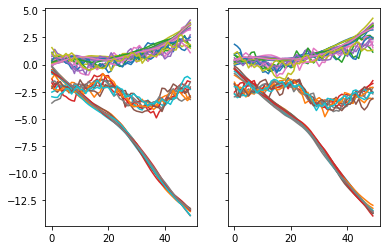

In [100]:
sample = post_dist_.sample(seed=key, sample_shape=(10,))
_, axes = plt.subplots(1, 2, sharey=True)
for i in range(10):
    axes[0].plot(sample[i])
sample = post_dist.sample(seed=key, sample_shape=(10,))
for i in range(10):
    axes[1].plot(sample[i])

Sampling also works!

# Define our prior and posterior objects

In [ ]:
def random_rotation(seed, n, theta=None):
    key1, key2 = jr.split(seed)

    if theta is None:
        # Sample a random, slow rotation
        theta = 0.5 * np.pi * jr.uniform(key1)

    if n == 1:
        return jr.uniform(key1) * np.eye(1)

    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    out = np.eye(n)
    out = out.at[:2, :2].set(rot)
    q = np.linalg.qr(jr.uniform(key2, shape=(n, n)))[0]
    return q.dot(out).dot(q.T)

# Helper function: solve a linear regression given expected sufficient statistics
def fit_linear_regression(Ex, Ey, ExxT, EyxT, EyyT, En):
    big_ExxT = np.row_stack([np.column_stack([ExxT, Ex]),
                            np.concatenate( [Ex.T, np.array([En])])])
    big_EyxT = np.column_stack([EyxT, Ey])
    Cd = np.linalg.solve(big_ExxT, big_EyxT.T).T
    C, d = Cd[:, :-1], Cd[:, -1]
    R = (EyyT - 2 * Cd @ big_EyxT.T + Cd @ big_ExxT @ Cd.T) / En

    # Manually symmetrize R
    R = (R + R.T) / 2
    return C, d, R

In [ ]:
class SVAEPrior:
    def init(self, key):
        """
        Returns the initial prior parameters.
        """
        pass

    def distribution(self, prior_params):
        """
        Returns a tfp distribution object
        Takes constrained params
        """
        pass

    def m_step(self, prior_params, posterior, post_params):
        """
        Returns updated prior parameters.
        """
        pass
    
    def sample(self, params, shape, key):
        return self.distribution(
            self.get_constrained_params(params)).sample(shape, seed=key)

    def get_constrained_params(self, params):
        return deepcopy(params)

    @property
    def shape(self):
        raise NotImplementedError

class LinearGaussianChain(SVAEPrior):

    # We're not using this at the moment
    # COVARIANCE_REGULARIZATION = 1e-3

    def __init__(self, latent_dims, seq_len):
        self.latent_dims = latent_dims
        # The only annoying thing is that we have to specify the sequence length
        # ahead of time
        self.seq_len = seq_len

    @property
    def shape(self):
        return (self.seq_len, self.latent_dims)

    # Must be the full set of constrained parameters!
    def distribution(self, params):
        J, L, h = params["J"], params["L"], params["h"]
        log_Z, J_filtered, h_filtered = params["log_Z"], params["J_filtered"], params["h_filtered"]
        Ex, ExxT, ExnxT = params["Ex"], params["ExxT"], params["ExnxT"]
        return MultivariateNormalBlockTridiag(J, L, h, 
            log_Z, J_filtered, h_filtered, Ex, ExxT, ExnxT)

    def init(self, key):
        T, D = self.seq_len, self.latent_dims
        key_A, key = jr.split(key, 2)
        params = {
            "m1": np.zeros(D),
            "Q1": np.eye(D),
            "A": random_rotation(key_A, D, theta=np.pi/20),
            "b": np.zeros(D),
            "Q": np.eye(D)
        }
        constrained = self.get_constrained_params(params)
        params["avg_suff_stats"] = { "Ex": constrained["Ex"], 
                                    "ExxT": constrained["ExxT"], 
                                    "ExnxT": constrained["ExnxT"] }
        return params

    def get_dynamics_params(self, params):
        return params

    def get_constrained_params(self, params):
        p = dynamics_to_tridiag(params, self.seq_len, self.latent_dims)
        J, L, h = p["J"], p["L"], p["h"]
        dist = MultivariateNormalBlockTridiag.infer(J, L, h)
        p.update({
            "log_Z": dist.log_normalizer,
            "J_filtered": dist.filtered_precisions,
            "h_filtered": dist.filtered_linear_potentials,
            "Ex": dist.expected_states,
            "ExxT": dist.expected_states_squared,
            "ExnxT": dist.expected_states_next_states
        })
        return p

    # This is pretty much deprecated since we're using sgd
    def m_step(self, prior_params):
        suff_stats = prior_params["avg_suff_stats"]
        ExxT = suff_stats["ExxT"]
        ExnxT = suff_stats["ExnxT"]
        Ex = suff_stats["Ex"]
        seq_len = Ex.shape[0]
        # Update the initials
        m1 = Ex[0]
        Q1 = ExxT[0] - np.outer(m1, m1)
        D = self.latent_dims
        A, b, Q = fit_linear_regression(Ex[:-1].sum(axis=0), 
                                        Ex[1:].sum(axis=0), 
                                        ExxT[:-1].sum(axis=0), 
                                        ExnxT.sum(axis=0), 
                                        ExxT[1:].sum(axis=0), 
                                        seq_len - 1)
        out = { "m1": m1, "Q1": Q1, "A": A, "b": b, "Q": Q }
        out["avg_suff_stats"] = deepcopy(suff_stats)
        return out

# Technically these are not (homogenous) linear Gaussian chains...
class LinearGaussianChainPosterior(LinearGaussianChain):
    def init(self, key):
        T, D = self.seq_len, self.latent_dims
        params = {
            "J": np.tile(np.eye(D)[None], (T, 1, 1)),
            "L": np.zeros((T-1, D, D)),
            "h": np.zeros((T, D))
        }
        return self.get_constrained_params(params)

    def get_constrained_params(self, params):
        J, L, h = params["J"], params["L"], params["h"]
        dist = MultivariateNormalBlockTridiag.infer(J, L, h)
        params.update({
            "log_Z": dist.log_normalizer,
            "J_filtered": dist.filtered_precisions,
            "h_filtered": dist.filtered_linear_potentials,
            "Ex": dist.expected_states,
            "ExxT": dist.expected_states_squared,
            "ExnxT": dist.expected_states_next_states
        })
        return params

    def sufficient_statistics(self, params):
        return {
            "Ex": params["Ex"],
            "ExxT": params["ExxT"],
            "ExnxT": params["ExnxT"]
        }

# The SVAE version has an inference function 
# that combines prior and potential params
class LDSSVAEPosterior(LinearGaussianChainPosterior):
    def infer(self, prior_params, potential_params):
        prior_J, prior_L, prior_h = prior_params["J"], prior_params["L"], prior_params["h"]
        params = {
            "J": prior_J + potential_params["J"],
            "L": prior_L,
            "h": prior_h + potential_params["h"]
        }
        return self.get_constrained_params(params)

# Takes a linear Gaussian chain as its base
class LDS(LinearGaussianChain):
    def __init__(self, latent_dims, seq_len, base=None):
        super().__init__(latent_dims, seq_len)
        self.posterior = LDSSVAEPosterior(latent_dims, seq_len)
        self.base = base or LinearGaussianChain(latent_dims, seq_len) # Slightly redundant...

    # Takes unconstrained params
    def sample(self, params, shape, key):
        latents = self.base.sample(params, shape, key)
        sample_shape = latents.shape[:-1]
        key, _ = jr.split(key)
        C, d, R = params["C"], params["d"], params["R"]
        obs_noise = tfd.MultivariateNormalFullCovariance(loc=d, covariance_matrix=R)\
            .sample(sample_shape=sample_shape, seed=key)
        obs = np.einsum("ij,...tj->...ti", C, latents) + obs_noise
        return latents, obs

    # Should work with any batch dimension
    def log_prob(self, params, states, data):
        latent_dist = self.base.distribution(self.base.get_constrained_params(params))
        latent_ll = latent_dist.log_prob(states)
        C, d, R = params["C"], params["d"], params["R"]
        # Gets around batch dimensions
        noise = tfd.MultivariateNormalFullCovariance(loc=d, covariance_matrix=R)
        obs_ll = noise.log_prob(data - np.einsum("ij,...tj->...ti", C, states))
        return latent_ll + obs_ll.sum(axis=-1)

    # Assumes single data points
    def e_step(self, params, data):
        # Shorthand names for parameters
        C, d, R = params["C"], params["d"], params["R"]

        J = np.dot(C.T, np.linalg.solve(R, C))
        J = np.tile(J[None, :, :], (self.seq_len, 1, 1))
        # linear potential
        h = np.dot(data - d, np.linalg.solve(R, C))

        return self.posterior.infer(self.base.get_constrained_params(params), {"J": J, "h": h})
        
    # Also assumes single data points
    def marginal_log_likelihood(self, params, data):
        posterior = self.posterior.distribution(self.e_step(params, data))
        states = posterior.mean()
        lps = self.log_prob(params, states, data) - posterior.log_prob(states)
        return lps